# Introduction to Neural Networks


** Ecole Centrale Nantes **

** Diana Mateus **


** Participants : **
## Raphael Blanchard, So Onishi


## General description
In this lab we will create a simple classifier based on neural networks. We will progress in two parts:
- In the first part, and to better understand the involved operations, we will create a single-neuron model and optimize its parameters "by hand". For this first part we will only use the **Numpy** library
- We will then build a CNN with the built-in **Keras** module from **tensorflow**. Tensorflow is already installed in the university computers. If using your own computer you should have already installed **tensorflow** or use **collab** online platform.




In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

### Loading the dataset
Start by runing the following lines to load and visualize the data.

In [2]:
# UNCOMMENT IF USING COLAB
#from google.colab import drive
#drive.mount('/content/drive')
#IMDIR = '/content/drive/MyDrive/Colab Notebooks/2022-2023 Machine Learning/05-neural networks/'

In [3]:
def load_dataset(IMDIR):
    train_dataset = h5py.File(IMDIR+'dataset/train_catvnoncat.h5', "r")
    train_x = np.array(train_dataset["train_set_x"][:])
    train_y = np.array(train_dataset["train_set_y"][:])
    test_dataset = h5py.File(IMDIR+'dataset/test_catvnoncat.h5', "r")
    test_x = np.array(test_dataset["test_set_x"][:])
    test_y = np.array(test_dataset["test_set_y"][:])
    classes = np.array(test_dataset["list_classes"][:])

    train_y = train_y.reshape((1, train_y.shape[0]))
    test_y = test_y.reshape((1, test_y.shape[0]))

    return train_x, train_y, test_x, test_y, classes

IMDIR = './dataset/'

train_x, train_y, test_x, test_y, classes=load_dataset(IMDIR)

#### Visualize data

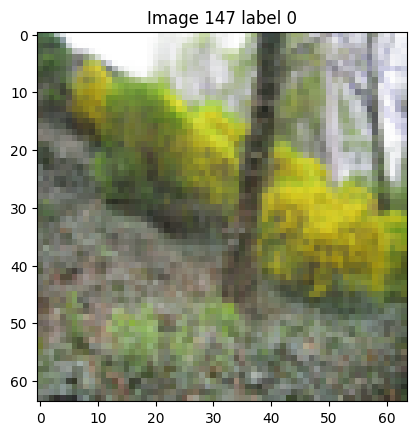

Train X shape: (209, 64, 64, 3)
We have 209 images of dimensionality 64x64x3


In [4]:
# run several times to visualize different data points
# the title shows the ground truth class labels (0=no cat , 1 = cat)
index = np.random.randint(low=0,high=train_y.shape[1])
plt.imshow(train_x[index])
plt.title("Image "+str(index)+" label "+str(train_y[0,index]))
plt.show()
print ("Train X shape: " + str(train_x.shape))
print ("We have "+str(train_x.shape[0]),
       "images of dimensionality "
       + str(train_x.shape[1])+ "x"
       + str(train_x.shape[2])+ "x"
       + str(train_x.shape[3]))

#### Preprocessing
In the following lines we vectorize the images (Instead of a 2-D image we will give as input to the models a 1-D vector). The normalization makes the image intensities be between 0 and 1, and converts the images to floats.

In [5]:
train_x, train_y, test_x, test_y, classes=load_dataset(IMDIR)
print ("Original train X shape: " + str(train_x.shape))
print ("Original test X shape: " + str(test_x.shape))
train_x = train_x.reshape(train_x.shape[0], -1).T
test_x = test_x.reshape(test_x.shape[0], -1).T
print ("Train X shape: " + str(train_x.shape))
print ("Train Y shape: " + str(train_y.shape))
print ("Test X shape: " + str(test_x.shape))
print ("Test Y shape: " + str(test_y.shape))

Original train X shape: (209, 64, 64, 3)
Original test X shape: (50, 64, 64, 3)
Train X shape: (12288, 209)
Train Y shape: (1, 209)
Test X shape: (12288, 50)
Test Y shape: (1, 50)


In [6]:
train_x = train_x/255.
test_x = test_x/255.

### 1. Classification with a single neuron


**a)** Fill-in the following three functions to define the single neuron model (a single neuron in the hidden layer):
- A function **initialize_parameters**, which given the number of desired weights ```dim```  it inizializes the neuron parameters.  
> The function will initialize:
> * the model's weights $\mathbf{w}$ by randomly, by sampling small values from a normal distribution (**Hint:** np.random.randn).
> * the bias $b$ with 0.
What is the number of weights required? pass this information as a parameter to the function.
- A function **sigmoid** that computes the sigmoid activation function
- A function **neuron** that given an input vector, the weights and bias, computes the output of the single neuron model

In [7]:
def sigmoid(z):
    return 1/(1+np.exp(-z+1e-8))

In [8]:
def initialize_parameters(dim):
    w = np.random.randn(dim, 1)*0.01
    b = np.zeros((1, ))
    return w, b

In [9]:
def neuron(w,b,x):
    pred_y = np.dot(w.T,x) + b
    return pred_y

**b)** **Forward Pass:**
Use the three functions above to compute a first forward pass for the input matrix $X$ containing the loaded dataset, for some initialization of the weights and bias.

 \begin{align}
 Y_{\rm pred}=\sigma(w^\top X+b) = [y_{\rm pred}^{(1)},y_{\rm pred}^{(2)},\dots,y_{\rm pred}^{(m)}]
 \end{align}


In [10]:
w, b = initialize_parameters(train_x.shape[0])
pred_y = sigmoid(neuron(w, b, train_x))

print(w.shape)
print(b.shape)
print(pred_y.shape)

(12288, 1)
(1,)
(1, 209)


**c) Cost estimation:**

We will use a binary cross-entropy loss, so that the empirical risk can be computed as:

 \begin{align}
 E = - \frac{1}{m} \sum_{i=1}^m
 y^{(i)} \log(y_{\rm pred}^{(i)}) +
 (1-y^{(i)}) \log(1-y_{\rm pred}^{(i)})
 \end{align}

 The following cross-entropy function should give as result the **scalar** cost value computed over the entire dataset

In [11]:
def crossentropy(Y, Ypred, epsilon =1e-8):
    m = Y.shape[1]
    cost = (-1/m) * np.sum(Y*np.log(Ypred+epsilon) + (1-Y)*np.log(1-Ypred+epsilon))

    return cost

cost_test = crossentropy(train_y,pred_y)
print("first cost: ", cost_test)

first cost:  0.6811379877291386


**d) Back propagation:**

After initializing the parameters and doing a forward pass, we need to backpropagate the cost by computing the gradient with respect to the model parameters to later update the weights

\begin{align}
\frac{\partial E}{\partial w} = 
& \frac{1}{m} X(Y_{\rm pred}-Y)^T = 
 \frac{1}{m} \sum_{i=1}^m x^{(i)}(y^{(i)}_{\rm pred}-y^{(i)})\\
\frac{\partial E}{\partial b} = 
& \frac{1}{m} \sum_{i=1}^m(y^{(i)}_{\rm pred}-y^{(i)})\\
\end{align}

See a demonstration of the gradient computation in
https://en.wikipedia.org/wiki/Cross_entropy

Fill-in the backpropagation function which receives as input the the training set (X,Y), as well as the current predictions and returns the gradients updates for the weights and bias

Hint: When the error is computed for several samples simultaneously, the gradient is averaged over the contribution of different samples.


In [12]:
def backpropagate(X, Y, Ypred):
    m = X.shape[1]

    #find gradient (back propagation)
    dw = (1/m) * np.dot(X,(Ypred-Y).T)
    db = (1/m) * np.sum(Ypred - Y)
    grads = {"dw": dw,
             "db": db}

    return grads

test_grads = backpropagate(train_x, train_y, pred_y)
print(test_grads["dw"].shape)
print(test_grads["db"].shape)

(12288, 1)
()


**e) Optimization**
After initializing the parameters, computing the cost function, and calculating gradients, we can now update the parameters using gradient descent. Use the functions implemented above to fill_in the "gradient_descent" function that optimizes the parameters given a training set X, Y, a fixed number of iterations, and a learning_rate. Store and plot the value of the loss function at each iteration

In [13]:
def gradient_descent(X, Y, iterations, learning_rate, printer=True):
    costs = []
    w, b = initialize_parameters(train_x.shape[0])

    for i in range(iterations):
        Ypred = sigmoid(neuron(w, b, X))
        cost = crossentropy(Y, Ypred)
        grads = backpropagate(X, Y, Ypred)

        #update parameters
        w = w - learning_rate*grads["dw"]
        b = b - learning_rate*grads["db"]
        costs.append(cost)
    
        if i % 100 == 0:
            if printer:
                print("Cost after iteration %i: %f" %(i, cost))

    return w,b, costs

w, b, costs = gradient_descent(train_x,train_y,iterations=2000, learning_rate = 0.005)

Cost after iteration 0: 0.687236


Cost after iteration 100: 0.584440
Cost after iteration 200: 0.467006
Cost after iteration 300: 0.376104
Cost after iteration 400: 0.331513
Cost after iteration 500: 0.303311
Cost after iteration 600: 0.279909
Cost after iteration 700: 0.260065
Cost after iteration 800: 0.242958
Cost after iteration 900: 0.228017
Cost after iteration 1000: 0.214828
Cost after iteration 1100: 0.203084
Cost after iteration 1200: 0.192547
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174396
Cost after iteration 1500: 0.166517
Cost after iteration 1600: 0.159299
Cost after iteration 1700: 0.152661
Cost after iteration 1800: 0.146534
Cost after iteration 1900: 0.140863


**f) Plot the training loss curve**
Plot the evolution of the loss against the iterations

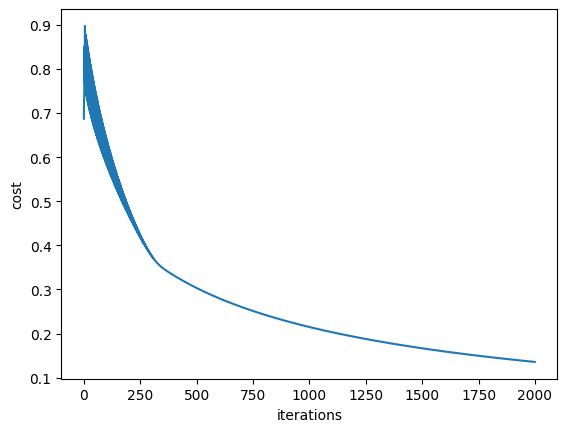

In [14]:
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations')
plt.show()

**g) Prediction**
Use the optimized parameters to make predictions both for the train and test sets and compute the accuracy for each. What do you observe?

In [15]:
def predict(w, b, X):
    y_pred = sigmoid(neuron(w, b, X))
    return y_pred

# predict
train_pred_y = predict(w, b, train_x)
test_pred_y = predict(w, b, test_x)
print("Train Acc: {} %".format(100 - np.mean(np.abs(train_pred_y - train_y)) * 100))
print("Test Acc: {} %".format(100 - np.mean(np.abs(test_pred_y - test_y)) * 100))

print()

Train Acc: 88.0721891413606 %
Test Acc: 64.84882749392116 %



**h)Choose learning rate on a validation set** Use 10% of the training data as validation to choose the learning rate. What are the best results you can obtain? (use only the validation data to choose, buy repport the accuracy on the train and test data)


In [16]:
print("training shape before splitting")
print(train_x.shape)
print(train_y.shape)

# defining the validation split which is of 10% here
val_split = 0.1

X_val = train_x[:, :int(np.ceil(val_split*train_x.shape[1]))]
Y_val = train_y[:, :int(np.ceil(val_split*train_x.shape[1]))]

X_train = train_x[:, int(np.ceil(val_split*train_x.shape[1])):]
Y_train = train_y[:, int(np.ceil(val_split*train_x.shape[1])):]

print("training shape after splitting")
print(X_train.shape)
print(Y_train.shape)

print("val shape after splitting")
print(X_val.shape)
print(Y_val.shape)

training shape before splitting
(12288, 209)
(1, 209)
training shape after splitting
(12288, 188)
(1, 188)
val shape after splitting
(12288, 21)
(1, 21)


In [18]:
learning_rates = [0.001*i for i in range(1, 16)]
print(learning_rates)

weights = {}
biases = {}
train_accuracies = {}
val_accuracies = {}
test_accuracies = {}

# do all the training for all the learning rates
for learning_rate in learning_rates:
    w, b, costs = gradient_descent(X_train,Y_train,iterations=2000, learning_rate = learning_rate, printer=False)
    # add the weights and biases 
    weights[learning_rate] = w
    biases[learning_rate] = b
    Y_pred_train = predict(w, b, X_train)
    Y_pred_val = predict(w, b, X_val)
    Y_pred_test = predict(w, b, test_x)
    train_accuracies[learning_rate] = 1 - np.mean(np.abs(Y_pred_train - Y_train))
    val_accuracies[learning_rate] = 1 - np.mean(np.abs(Y_pred_val - Y_val))
    test_accuracies[learning_rate] = 1 - np.mean(np.abs(Y_pred_test - test_y))

print(train_accuracies)
print(val_accuracies)
print(test_accuracies)


[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.01, 0.011, 0.012, 0.013000000000000001, 0.014, 0.015]
{0.001: 0.7461202944121654, 0.002: 0.8094268901221886, 0.003: 0.8463232546427785, 0.004: 0.8712595009676898, 0.005: 0.8894727165542665, 0.006: 0.9040007839165555, 0.007: 0.9159151493142728, 0.008: 0.9257620080564947, 0.009000000000000001: 0.9339586565017453, 0.01: 0.940848804111956, 0.011: 0.9468602154054365, 0.012: 0.9520073274110575, 0.013000000000000001: 0.9565230848722043, 0.014: 0.9605881342392226, 0.015: 0.9641906336296099}
{0.001: 0.5837234639806717, 0.002: 0.5833317411103927, 0.003: 0.579312627069599, 0.004: 0.5753238040575155, 0.005: 0.5733516171526446, 0.006: 0.5710467085057606, 0.007: 0.5703720593016435, 0.008: 0.5698238832831266, 0.009000000000000001: 0.5697123421345712, 0.01: 0.5692731104117625, 0.011: 0.5692137415595682, 0.012: 0.5706140671863522, 0.013000000000000001: 0.5708735532668687, 0.014: 0.5720161672371972, 0.015: 0.575212722320677

In [20]:
best_lr = max(val_accuracies, key=lambda k: val_accuracies[k])

print("Best learning rate for validation accuracy", best_lr)
print("Using learning_rate = ", best_lr, ": ")
print("train acc: ", train_accuracies[best_lr])
print("val acc: ", val_accuracies[best_lr])
print("test acc: ", test_accuracies[best_lr])

Best learning rate for validation accuracy 0.001
Using learning_rate =  0.001 : 
train acc:  0.7461202944121654
val acc:  0.5837234639806717
test acc:  0.5867788759026289
